In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
train_features = pd.read_csv('train_features.csv')

train_targets = pd.read_csv('train_targets.csv', names = ["target"], header=0)

# Data viz

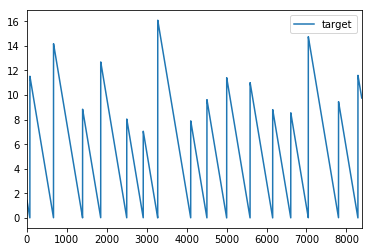

In [63]:
train_targets.plot()

# Get indices of signal start

In [0]:
def sep_signals(df, precision, nb_sig):
  res = []
  idx = 0
  stop = nb_sig
  while (((idx * precision) < df.shape[0] - 2 * precision) and (len(res) < stop)):
    while (df['target'][idx* precision] > df['target'][(idx+1)*precision]):
      idx += 1
    res += [idx * precision]
    idx += 1
    print("added ",idx * precision)
  return res

In [65]:
separators = sep_signals(train_targets, 1, 16)

added  74
added  666
added  1394
added  1848
added  2500
added  2913
added  3276
added  4102
added  4508
added  5003
added  5589
added  6155
added  6608
added  7047
added  7804
added  8290


In [66]:
print(train_targets.iloc[73])
print(train_targets.iloc[74])

target    0.008299
Name: 73, dtype: float64
target    11.530097
Name: 74, dtype: float64


# Split training and validation signals before padding

If we don't do it, every signal will be padded with some information coming from other signals. That means the validation set will contain overlapping information with the training dataset, and lead to overfitting.

In [0]:
# Take two last signals for validation purposes
df_train_x = train_features.loc[:7803]
df_train_y = train_targets.loc[:7803]

df_val_x = train_features.loc[7804:].reset_index(drop=True)
df_val_y = train_targets.loc[7804:].reset_index(drop=True)

In [68]:
df_train_x.shape

(7804, 485)

# Signal Separation

In [69]:
# Remove last two separators from list as corresponding signals have been moved to valid set
indices = sep_signals(df_train_y, 1, 14)

added  74
added  666
added  1394
added  1848
added  2500
added  2913
added  3276
added  4102
added  4508
added  5003
added  5589
added  6155
added  6608
added  7047


In [0]:
def split_signal(df_x, df_y, indices):
  indices += [df_y.shape[0]]
  signals = []
  previous_i = 0
  for i in indices:
    sig_x , sig_y = df_x.loc[previous_i + 1:i], df_y.loc[previous_i+1:i]
    signals += [(sig_x, sig_y)]
    previous_i = i
  return signals

Split the big signal into 16 parts corresponding to the 16 earthquakes

In [0]:
signals = split_signal(df_train_x, df_train_y, indices)

In [72]:
print(len(signals))
signals[1][1]

15


,target
74,11.530097
75,11.510996
76,11.490799
77,11.471598
78,11.452496
79,11.432199
80,11.413098
81,11.393896
82,11.373700
83,11.354598


Get the length of each signal

In [0]:
def len_of_sig(indices):
  sep = [0] + indices
  lengths = [(sep[i+1] - sep[i]) for i in range(len(sep) - 1) ]
  return lengths

In [0]:
signal_lengths = len_of_sig(indices)

In [75]:
signal_lengths

[73, 592, 728, 454, 652, 413, 363, 826, 406, 495, 586, 566, 453, 439, 758]

Get the indices of the signal from shortest to longest

In [76]:
argsort = np.argsort(signal_lengths)
argsort

array([ 0,  6,  8,  5, 13, 12,  3,  9, 11, 10,  1,  4,  2, 14,  7])

In [77]:
for elem in argsort:
  print(len(signals[elem][0]))

73
363
406
413
439
453
454
495
566
586
592
652
728
757
826


Get differences of lengths between two consecutive signals in terms  of duration

In [0]:
def cons_diff(lengths, argsort):
  diff = []
  for i in range(len(argsort) - 2,-1,-1):
    tmp = lengths[argsort[i+1]] - lengths[argsort[i]]
    diff += [tmp]
  return diff

In [79]:
differences = cons_diff(signal_lengths, argsort)
differences

[68, 30, 76, 60, 6, 20, 71, 41, 1, 14, 26, 7, 43, 290]

# Signal padding

Now that we have separated the signals, their lengths and the difference of time between two consecutive signals, we can smartly padd the signals so that they all have the same lengths, which is 809, the length of the longest signal.

In [0]:
def pad_signal(short_sig, padding):
  return pd.concat([padding, short_sig])

In [0]:
test = pad_signal(signals[argsort[-2]][0], signals[argsort[-1]][0].iloc[:69])

In [82]:
print(signals[argsort[-2]][0].shape)
print(test.shape)


(757, 485)
(826, 485)


We now extract chunks of signals. The first chunk is the beginning of the longest signal. After, we take the next small part of the first and the second (until we reach the start of the third longest signal), and so on.

In [0]:
def extract_chunks(signals, argsort, differences):
  chunks = []
  prev_diff = 0
  for count in range(len(differences)):
    tmp = []
    for i in range(count+1):
      tmp += [signals[argsort[len(argsort) - i - 1]][0].iloc[prev_diff:prev_diff + differences[count]]]
    chunks += [tmp]
    prev_diff += differences[count]
  return chunks

In [0]:
chunks = extract_chunks(signals, argsort, differences)

In [88]:
len(chunks)

14

Now we have to prepare the paddings. For this, we average the features over the chunks. To be able to do so, we need to reset the indices accross the dataframes.

In [0]:
def reset_indices(chunks):
  for i in range(len(chunks)):
    for j in range(i+1):
      chunks[i][j].reset_index(drop=True, inplace=True)
  return True

In [90]:
reset_indices(chunks)

True

In [0]:
def prepare_pad(chunks):
  average_chunks = []
  for elem in chunks:
    tmp = elem[0]
    if len(elem) > 1:
      for i in range(1, len(elem)):
        tmp = pd.concat((tmp,elem[i]))
    by_row_index = tmp.groupby(tmp.index)
    df_means = by_row_index.mean()
    average_chunks += [df_means]
  return average_chunks

In [0]:
average_chunks = prepare_pad(chunks)

In [93]:
len(average_chunks[1])

30

In [0]:
def pad_signals(signals, average_chunks, argsort):
  # reverse to have longest first
  argsort = argsort[::-1]
  padded_signals = []
  for i,index in enumerate(argsort):
    if i==0:
      padded_signals += [signals[index][0].reset_index(drop=True)]
    if i>0:
      signal_x = signals[index][0]
      for j in range(i,0,-1):
        padding = average_chunks[j-1]
        signal_x = pad_signal(signal_x, padding)
        signal_x.reset_index(drop=True, inplace=True)
      padded_signals += [signal_x]
  return padded_signals

In [0]:
padded_signals = pad_signals(signals, average_chunks, argsort)

In [0]:
def save_signals(padded_signals):
  basename = "signal_"
  csv = ".csv"
  for i,sig in enumerate(padded_signals):
    name = basename + str(i) + csv
    sig.to_csv(name, index=False)
  return True

In [0]:
save_signals(padded_signals)

True

In [103]:
padded_signals[14]

,mean,std,skew,kurtosis,min,max,max_min_diff,max_over_min,sta_lta_0_mean,sta_lta_0_std,...,ac_lag_700_to_800_e_5000,ac_lag_8_e_5000,ac_lag_80_to_90_e_5000,ac_lag_800_to_900_e_5000,ac_lag_9_e_5000,ac_lag_90_to_100_e_5000,ac_lag_900_to_1000_e_5000,ac_lag_10_e_5000,ac_lag_100_to_110_e_5000,ac_lag_1000_to_1100_e_5000
0,3.891073,3.031003,0.018471,7.459954,-37.0,54.0,17.0,1.459459,0.998449,0.102581,...,-0.008443,-0.057461,0.010789,-0.010051,-0.031834,0.004514,-0.022047,-0.014431,-0.000911,0.000729
1,3.919067,3.771084,0.562460,61.310967,-83.0,103.0,20.0,1.240964,1.007019,0.233794,...,0.011008,-0.599177,0.049686,-0.006925,-0.538461,-0.052609,0.000164,-0.404558,0.058051,-0.024770
2,3.913093,4.068210,0.476397,48.662514,-83.0,103.0,20.0,1.240964,1.000913,0.262923,...,0.008061,-0.107640,0.041106,0.006359,-0.078909,0.054560,0.047665,-0.036404,-0.013760,0.004789
3,3.997853,4.646028,1.053486,162.057286,-116.0,141.0,25.0,1.215517,0.999102,0.261509,...,0.014766,-0.177934,-0.028227,0.023998,-0.188495,0.060620,-0.013215,-0.171259,-0.022333,0.056182
4,4.118407,4.587033,0.952039,178.418664,-116.0,141.0,25.0,1.215517,0.998327,0.277964,...,-0.000138,-0.018968,0.046692,0.020299,-0.030687,0.030760,0.001218,-0.052766,0.006824,0.006071
5,4.129220,3.610329,-0.185690,54.608358,-83.0,74.0,-9.0,0.891566,1.000355,0.226751,...,-0.018618,-0.161018,0.010289,-0.036360,-0.139847,0.051367,-0.030277,-0.118046,-0.013683,-0.029984
6,4.108067,3.468218,-0.025050,35.539159,-59.0,74.0,15.0,1.254237,0.999227,0.191011,...,-0.027324,-0.130085,0.030316,0.027115,-0.106077,-0.006357,-0.013184,-0.082603,-0.001754,0.021090
7,4.139787,3.377627,0.125223,12.538352,-41.0,61.0,20.0,1.487805,1.010736,0.130403,...,-0.005618,-0.109301,-0.022726,0.014014,-0.092637,0.090805,-0.037155,-0.080397,-0.032279,0.003520
8,4.195960,3.402871,0.165235,11.679801,-41.0,61.0,20.0,1.487805,0.998456,0.140643,...,-0.000767,-0.187354,-0.041322,0.011348,-0.149342,0.027633,-0.001615,-0.094861,0.002767,0.027993
9,4.174627,4.028800,0.086203,21.165181,-57.0,80.0,23.0,1.403509,1.010927,0.221759,...,-0.024907,-0.592497,-0.000901,-0.002790,-0.535164,0.060846,-0.005968,-0.417767,-0.076605,0.030580


In [0]:
def concat_sig(signals, padded_signals, train_targets, argsort):
  argsort = argsort[::-1]
  target = signals[argsort[0]][1]
  tmp = padded_signals[0]
  bar = target
  for i in range(1, len(padded_signals)):
    tmp = pd.concat((tmp,padded_signals[i]))
    bar = pd.concat((bar, target))
  bar.reset_index(drop=True, inplace=True)
  return tmp, bar

In [0]:
data, new_targets = concat_sig(signals, padded_signals, train_targets, argsort)

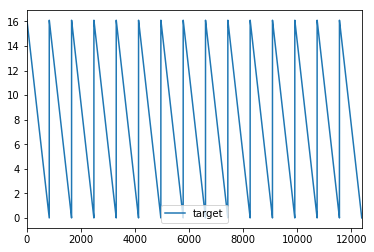

In [108]:
new_targets.plot()

In [0]:
data.to_csv("concat_padded_signals_train.csv", index=False)
new_targets.to_csv("concat_padded_targets_train.csv", index=False)

In [0]:
df_val_x.to_csv("unpadded_2_signals_test.csv", index=False)
df_val_y.to_csv("unpadded_2_targets_test.csv", index=False)